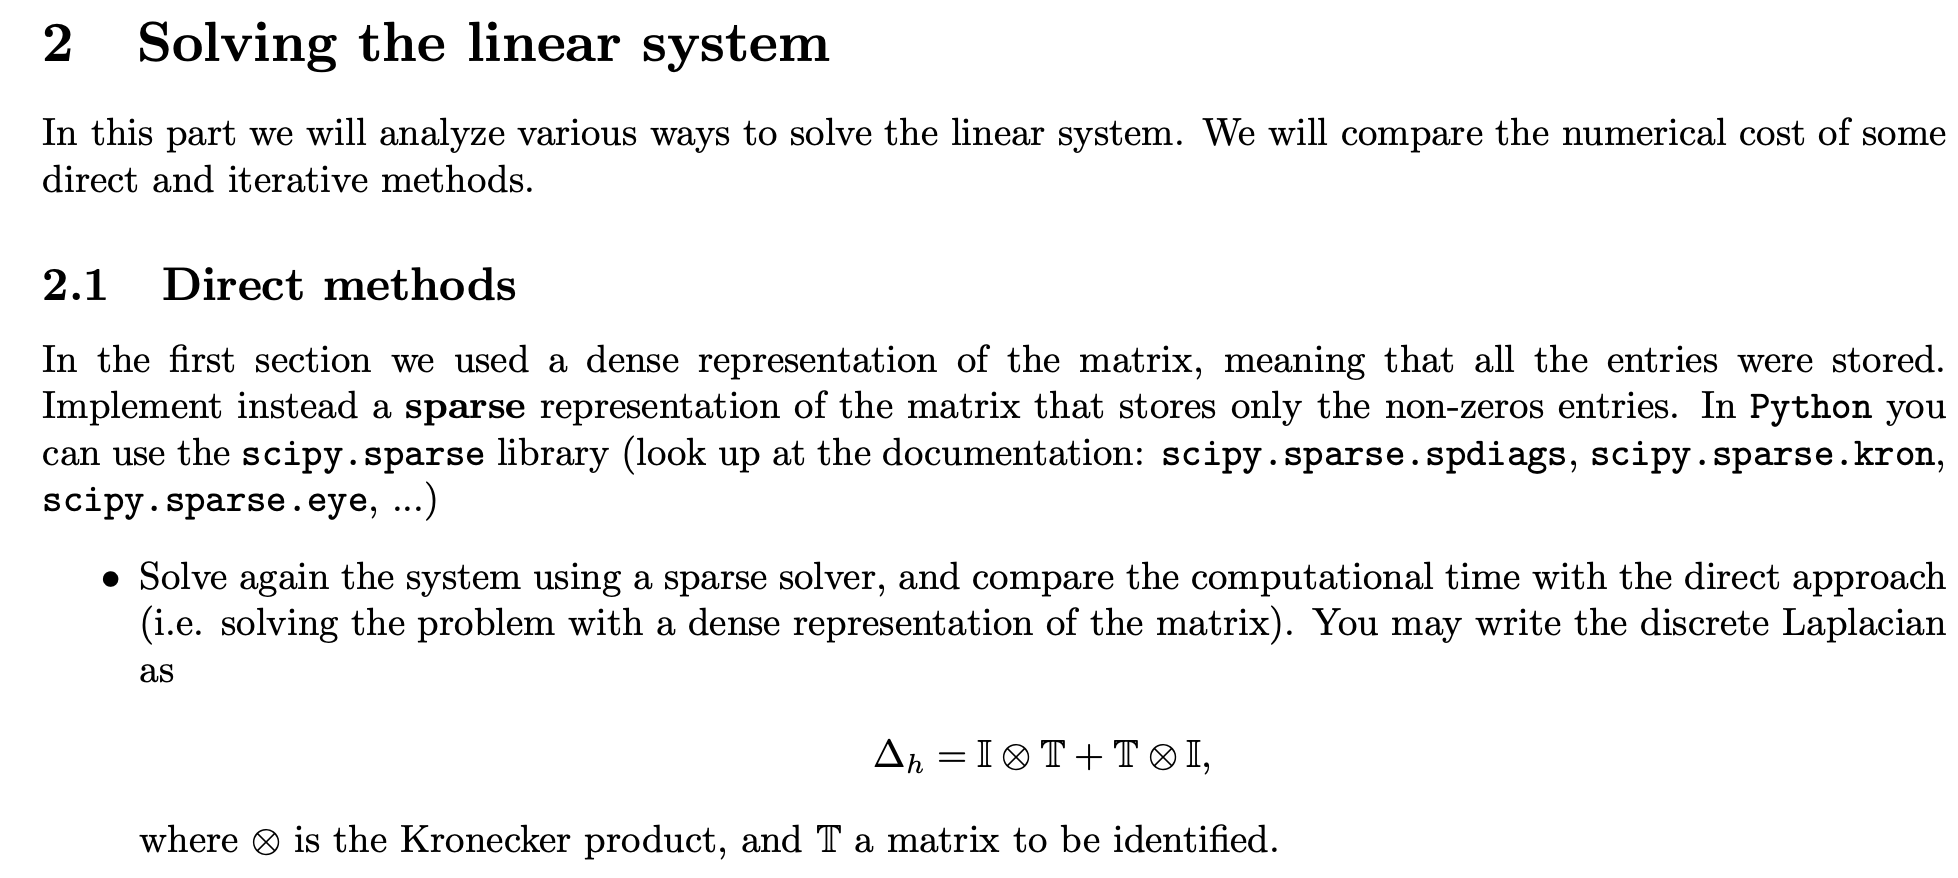

Sparse solver time: 0.0138 seconds
Dense solver time: 0.1094 seconds
Sparse Solver Numerical Results (Partial View):
[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.00004 0.00008 0.00015 0.00024 0.00036 0.00049 0.00065 0.00082
  0.00101]
 [0.      0.00008 0.00014 0.00022 0.00032 0.00045 0.0006  0.00077 0.00097
  0.00118]
 [0.      0.00015 0.00022 0.00029 0.00039 0.00051 0.00065 0.00081 0.00099
  0.00119]
 [0.      0.00024 0.00032 0.00039 0.00047 0.00058 0.0007  0.00084 0.001
  0.00117]
 [0.      0.00036 0.00045 0.00051 0.00058 0.00066 0.00076 0.00088 0.00101
  0.00115]
 [0.      0.00049 0.0006  0.00065 0.0007  0.00076 0.00084 0.00092 0.00101
  0.00111]
 [0.      0.00065 0.00077 0.00081 0.00084 0.00088 0.00092 0.00097 0.00102
  0.00108]
 [0.      0.00082 0.00097 0.00099 0.001   0.00101 0.00101 0.00102 0.00103
  0.00103]
 [0.      0.00101 0.00118 0.00119 0.00117 0.00115 0.00111 0.00108 0.00103
  0.00099]]


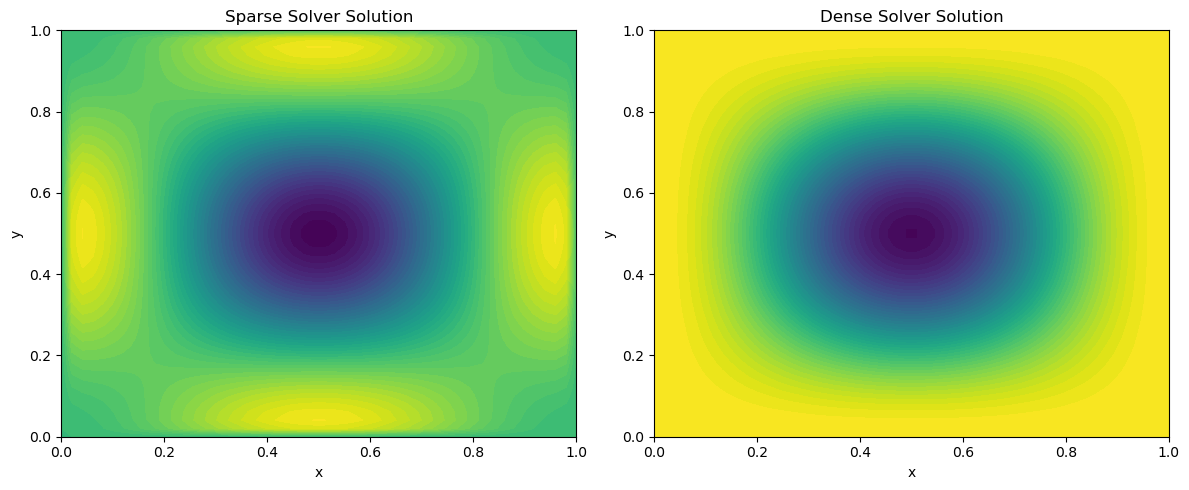

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve

def exact_solution(x, y):
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def source_term(x, y):
    return -4 * np.pi**2 * (np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 + np.sin(np.pi * x)**2 * np.cos(2 * np.pi * y))

# Step 1: Sparse Poisson solver with Kronecker product
def sparse_poisson_solver(Nx, Ny):
    h_x = 1 / (Nx - 1)
    h_y = 1 / (Ny - 1)
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)

    # Step 2: Tridiagonal matrix T for one direction (1D Laplacian)
    diagonal = -4 * np.ones(Nx - 1)
    off_diagonal = np.ones(Nx - 2)
    T = diags([diagonal, off_diagonal, off_diagonal], [0, -1, 1], shape=(Nx-1, Nx-1))

    # Step 3: Create the 2D Laplacian using Kronecker product
    Lx = kron(eye(Ny-1), T)  # 2D Laplacian in x direction
    Ly = kron(T, eye(Ny-1))  # 2D Laplacian in y direction
    L = Lx + Ly  # Full Laplacian matrix

    # Step 4: Set up the right-hand side f
    f = np.zeros((Nx-1, Ny-1))  # Right-hand side has (Nx-1)*(Ny-1) values
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            f[i-1, j-1] = source_term(x[i], y[j])  # Source term for interior points

    b = f.flatten() * h_x * h_y  # Flatten and scale by the grid size

    # Step 5: Solve the linear system using sparse solver
    u_sparse = spsolve(L, b)

    # Step 6: Reconstruct the solution on the grid
    U_sparse = np.zeros((Nx, Ny))  # The solution grid will be of size (Nx, Ny)
    U_sparse[1:Nx, 1:Ny] = u_sparse.reshape((Nx-1, Ny-1))  # Correct reshaping

    return U_sparse, x, y

# Step 2: Dense Poisson solver (for comparison)
def dense_poisson_solver(Nx, Ny):
    h_x = 1 / (Nx - 1)
    h_y = 1 / (Ny - 1)
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    
    # Step 2: Set up the discrete Laplacian matrix A (dense)
    N = (Nx - 1) * (Ny - 1)
    A = np.zeros((N, N))
    
    # Fill the matrix A (same as before)
    for j in range(Ny - 1):
        for i in range(Nx - 1):
            index = i + j * (Nx - 1)
            
            # Diagonal (center value)
            A[index, index] = -4
            
            # Off-diagonal (neighboring values)
            if i > 0:  # Left
                A[index, index - 1] = 1
            if i < Nx - 2:  # Right
                A[index, index + 1] = 1
            if j > 0:  # Down
                A[index, index - (Nx - 1)] = 1
            if j < Ny - 2:  # Up
                A[index, index + (Nx - 1)] = 1
    
    # Step 3: Set up the right-hand side vector f
    f = np.zeros((Nx - 1, Ny - 1))
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            f[i-1, j-1] = source_term(x[i], y[j])
    
    b = f.flatten() * h_x * h_y  # Flatten and scale by the grid size
    
    # Step 4: Solve the linear system using dense solver
    u_dense = np.linalg.solve(A, b)
    
    # Step 5: Reconstruct the solution on the grid
    U_dense = np.zeros((Nx, Ny))
    U_dense[1:Nx, 1:Ny] = u_dense.reshape((Nx-1, Ny-1))
    
    return U_dense, x, y

# Step 3: Run comparison and measure computational time
Nx = 50
Ny = 50

# Sparse solver
start_time = time.time()
U_sparse, x, y = sparse_poisson_solver(Nx, Ny)
sparse_time = time.time() - start_time
print(f"Sparse solver time: {sparse_time:.4f} seconds")

# Dense solver
start_time = time.time()
U_dense, x, y = dense_poisson_solver(Nx, Ny)
dense_time = time.time() - start_time
print(f"Dense solver time: {dense_time:.4f} seconds")

# Step 4: Plot solutions for comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Sparse solution plot
ax[0].contourf(x, y, U_sparse.T, 50, cmap='viridis')
ax[0].set_title('Sparse Solver Solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

# Dense solution plot
ax[1].contourf(x, y, U_dense.T, 50, cmap='viridis')
ax[1].set_title('Dense Solver Solution')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

# Print the numerical results for the sparse solution
print("Sparse Solver Numerical Results (Partial View):")
print(np.array2string(U_sparse[:10, :10], precision=5, suppress_small=True))
plt.tight_layout()
plt.show()

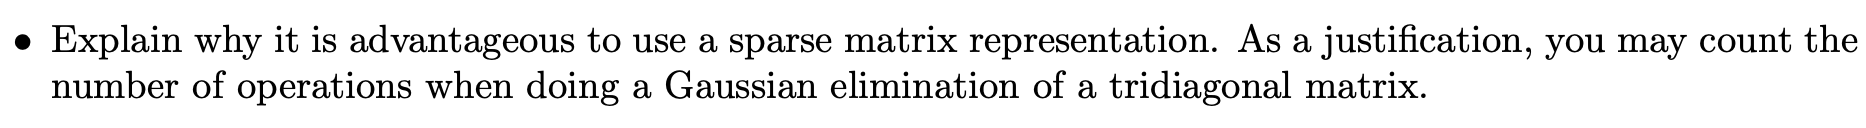

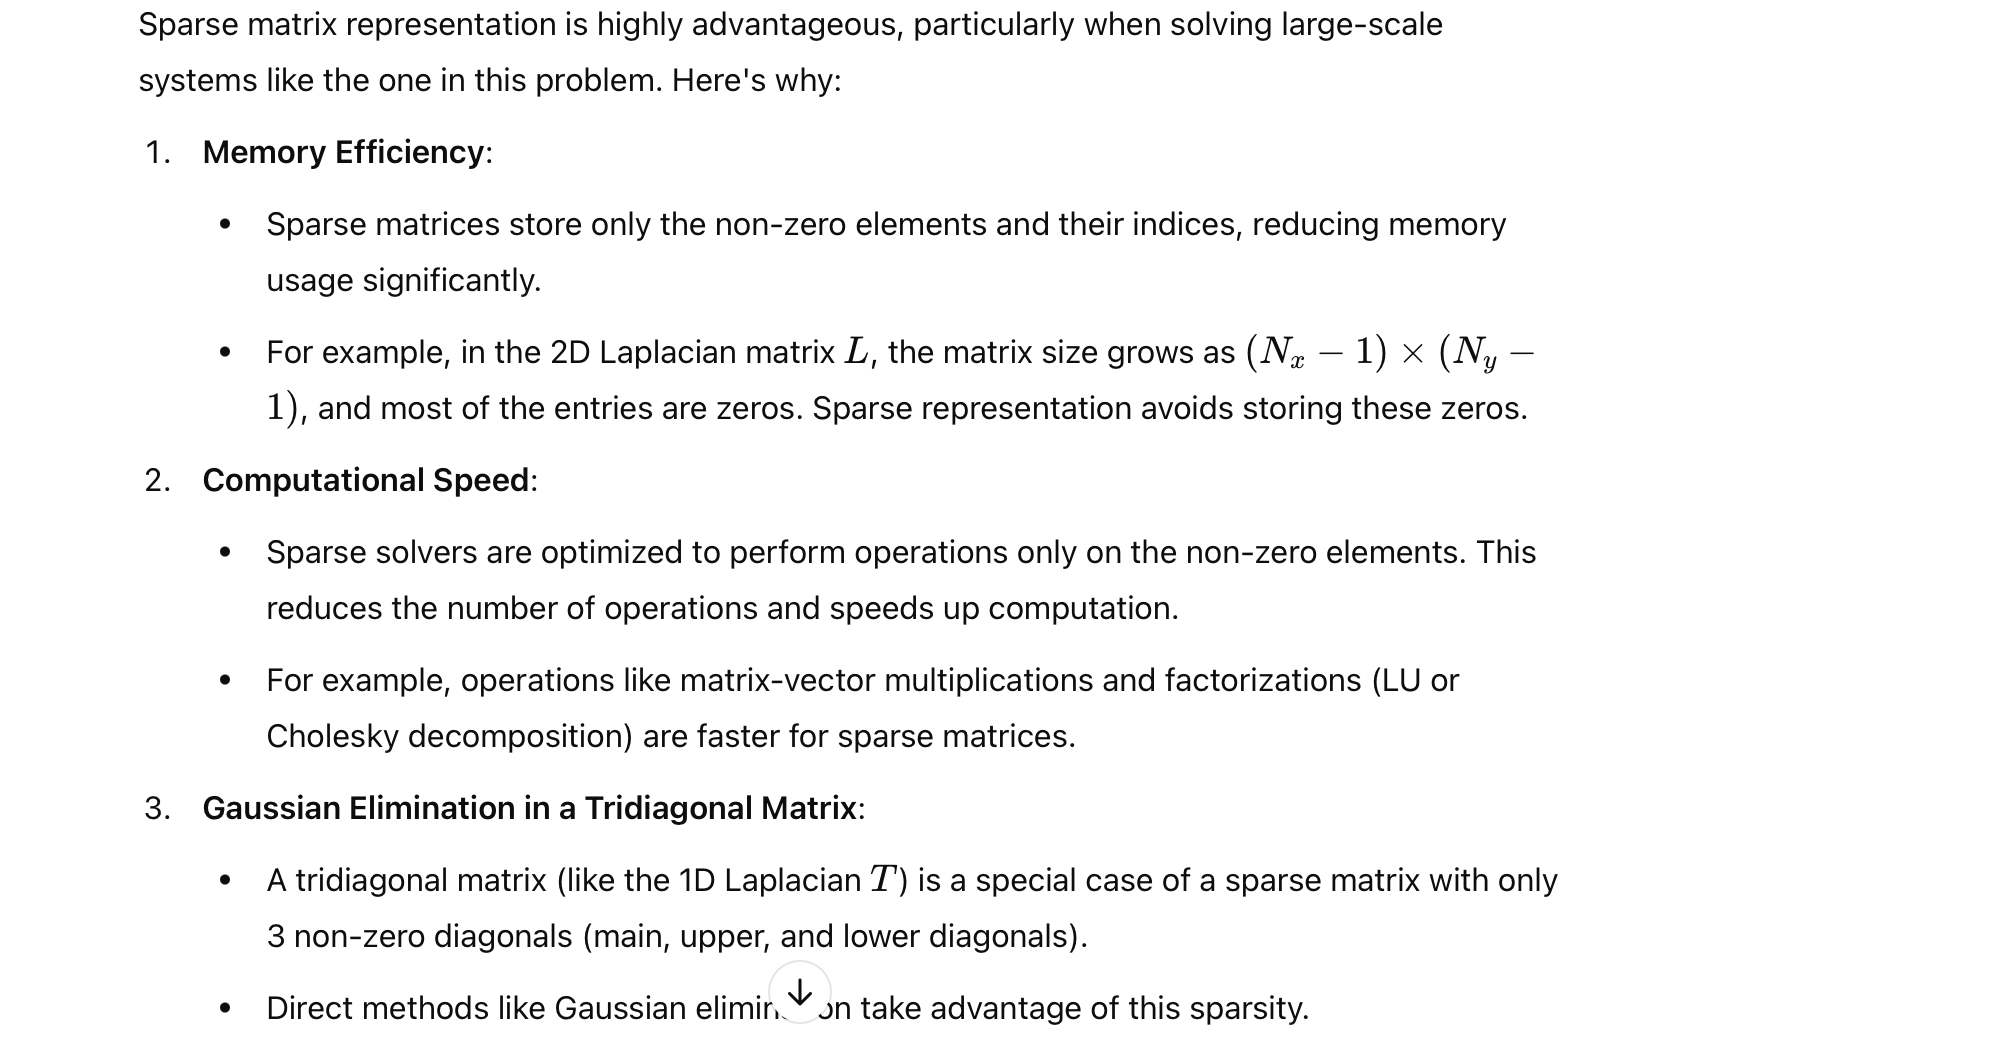
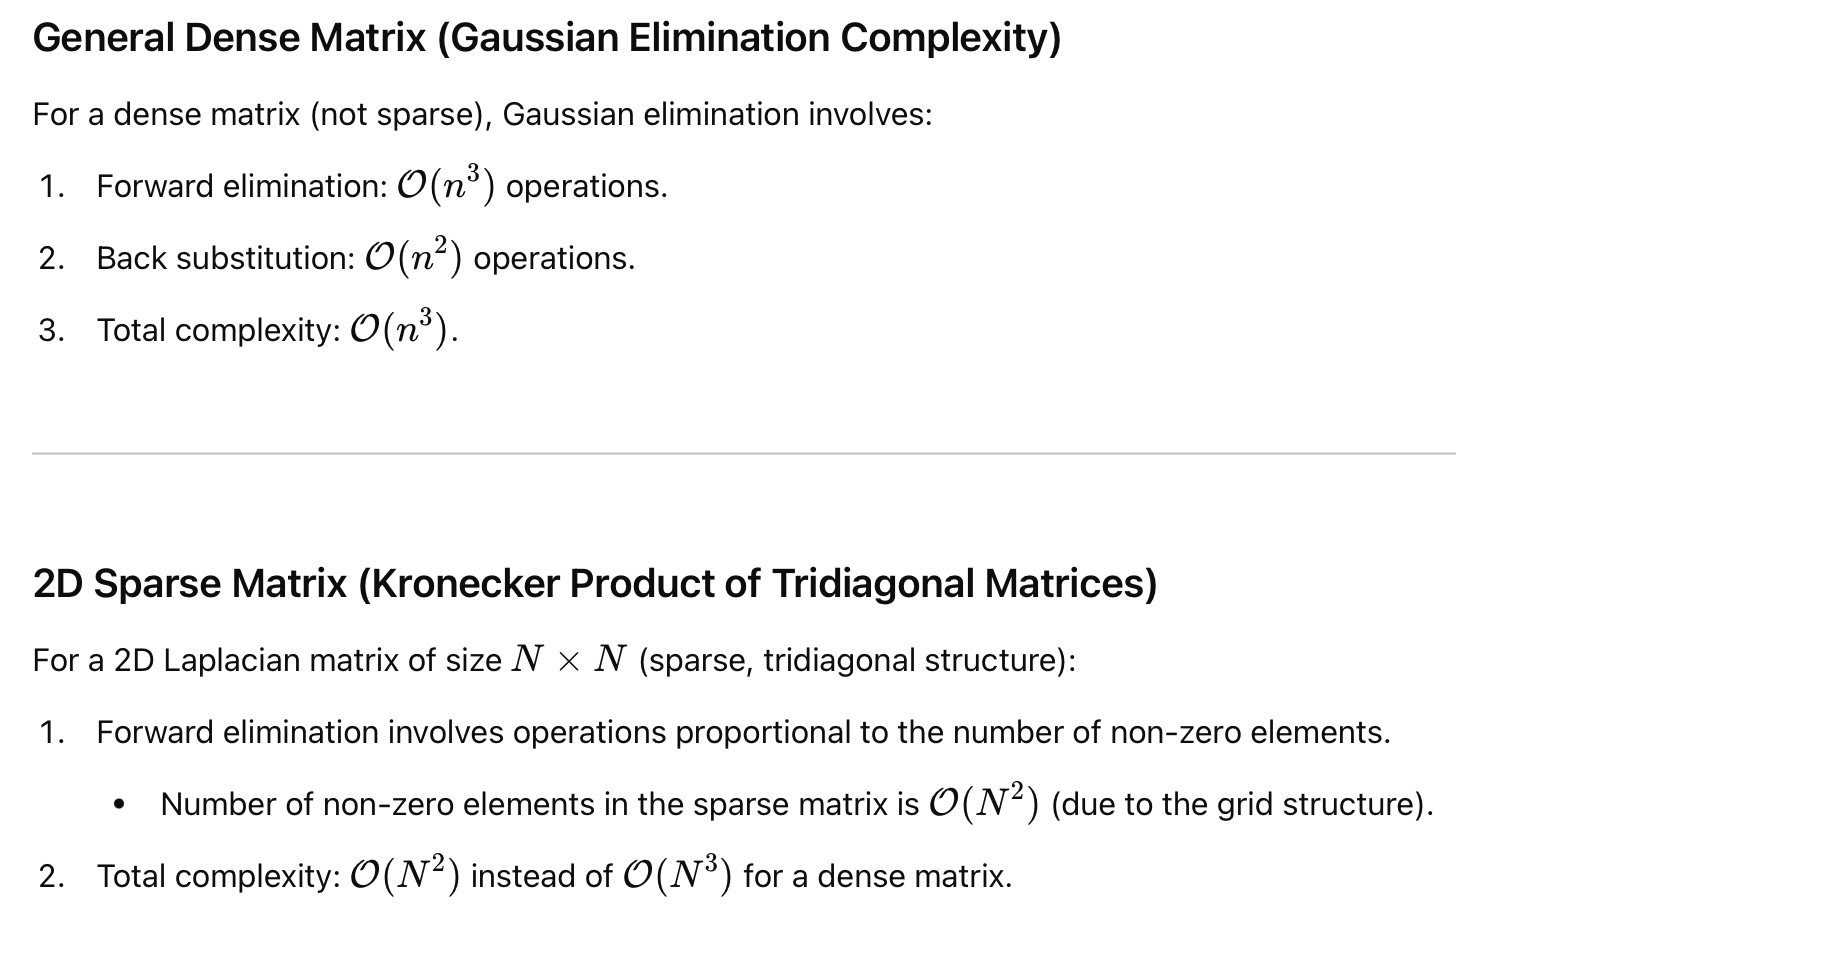

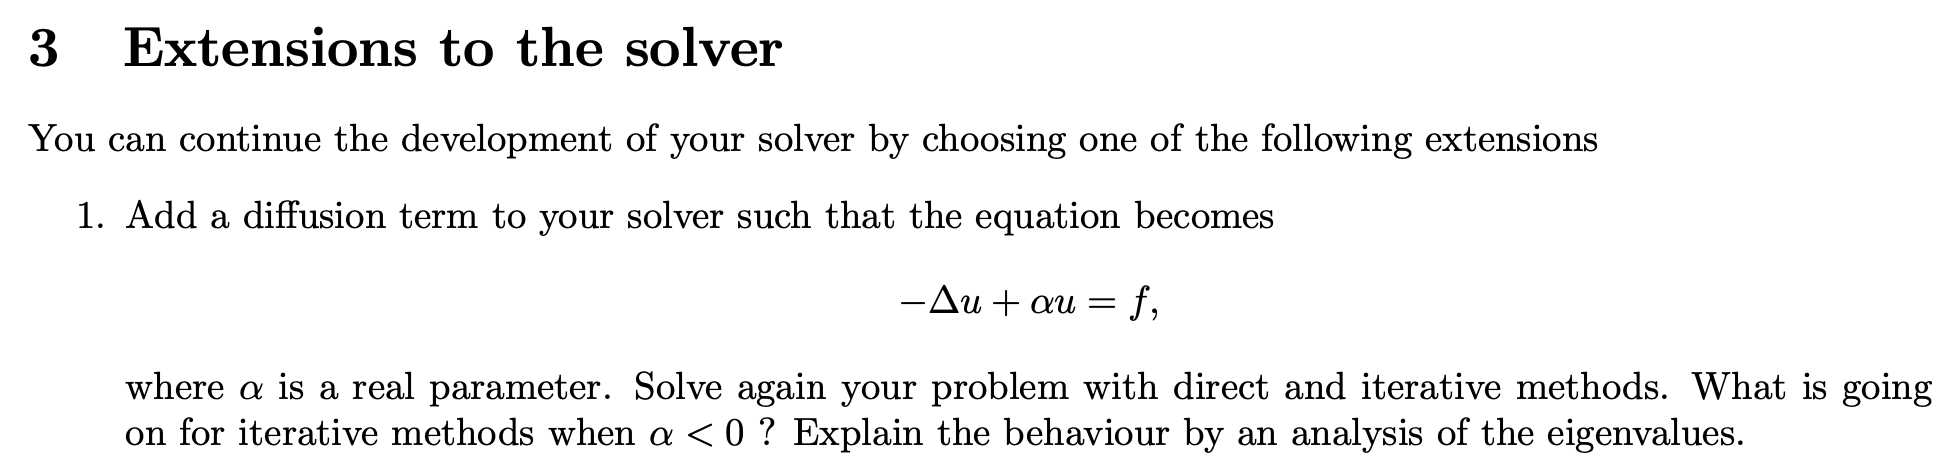

Sparse solver with diffusion time: 0.0170 seconds
Eigenvalues of the modified matrix: [-12.99210691 -12.96845881 -12.98028286 -12.98028286 -12.96062796
 -12.96062796]


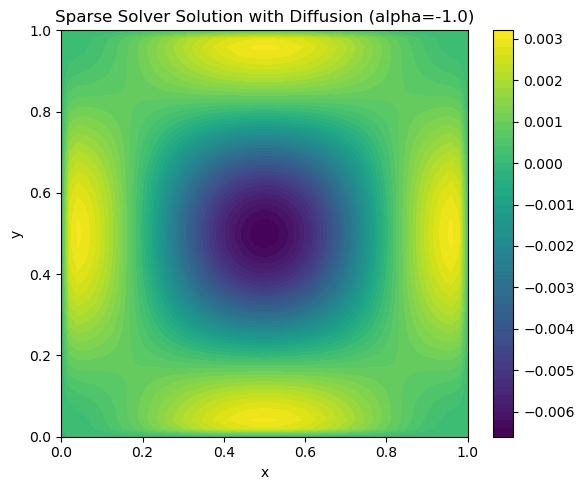

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve, eigs

def exact_solution(x, y):
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def source_term(x, y):
    return -4 * np.pi**2 * (np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 + np.sin(np.pi * x)**2 * np.cos(2 * np.pi * y))

def sparse_poisson_solver_with_diffusion(Nx, Ny, alpha):
    h_x = 1 / (Nx - 1)
    h_y = 1 / (Ny - 1)
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)

    diagonal = -4 * np.ones(Nx - 1)
    off_diagonal = np.ones(Nx - 2)
    T = diags([diagonal, off_diagonal, off_diagonal], [0, -1, 1], shape=(Nx-1, Nx-1))

    Lx = kron(eye(Ny-1), T)
    Ly = kron(T, eye(Ny-1))
    L = Lx + Ly

    # Add the diffusion term (alpha * I)
    I = eye((Nx-1) * (Ny-1))
    A = L + alpha * I

    f = np.zeros((Nx-1, Ny-1))
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            f[i-1, j-1] = source_term(x[i], y[j])

    b = f.flatten() * h_x * h_y
    u_sparse = spsolve(A, b)

    U_sparse = np.zeros((Nx, Ny))
    U_sparse[1:Nx, 1:Ny] = u_sparse.reshape((Nx-1, Ny-1))

    return U_sparse, x, y, A

def analyze_eigenvalues(A):
    # Compute a few eigenvalues to understand stability
    eigenvalues, _ = eigs(A, k=6, which='LM')  # Largest magnitude eigenvalues
    return np.real(eigenvalues)

# Parameters
Nx, Ny = 50, 50
alpha = -1.0  # Diffusion coefficient

# Solve with diffusion term
start_time = time.time()
U_sparse, x, y, A = sparse_poisson_solver_with_diffusion(Nx, Ny, alpha)
sparse_time = time.time() - start_time
print(f"Sparse solver with diffusion time: {sparse_time:.4f} seconds")

# Analyze eigenvalues
eigenvalues = analyze_eigenvalues(A)
print("Eigenvalues of the modified matrix:", eigenvalues)

# Plot the solution
plt.figure(figsize=(6, 5))
plt.contourf(x, y, U_sparse.T, 50, cmap='viridis')
plt.title(f'Sparse Solver Solution with Diffusion (alpha={alpha})')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.tight_layout()
plt.show()


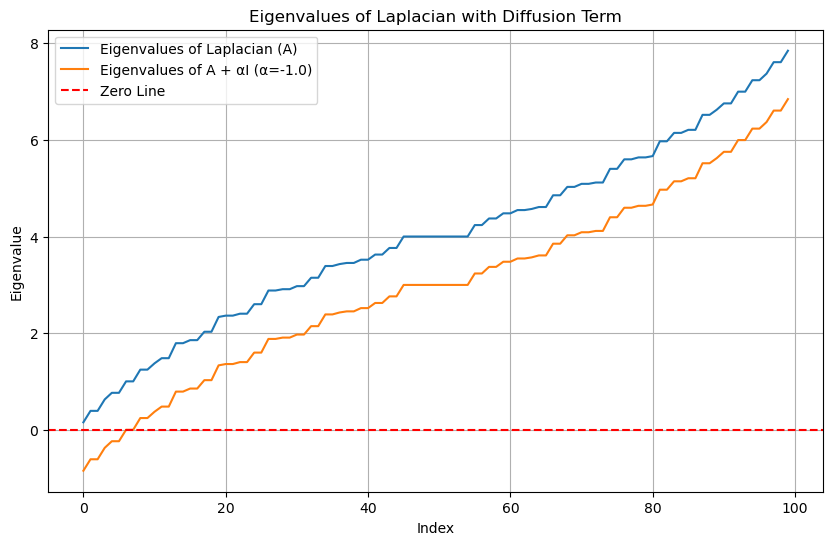

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def laplacian_eigenvalues(n, alpha):
    """
    Computes eigenvalues of the 2D Laplacian matrix with and without the diffusion term.
    
    Args:
        n (int): Grid size (n x n).
        alpha (float): Diffusion parameter.
    
    Returns:
        eigenvalues (np.array): Eigenvalues of the modified matrix.
    """
    # Compute eigenvalues of 1D Laplacian
    lambda_1D = [2 - 2 * np.cos(np.pi * i / (n + 1)) for i in range(1, n + 1)]
    
    # Compute eigenvalues of 2D Laplacian
    lambda_2D = [l1 + l2 for l1 in lambda_1D for l2 in lambda_1D]
    
    # Add the diffusion term
    eigenvalues = np.array(lambda_2D) + alpha
    return np.array(lambda_2D), eigenvalues

# Parameters
n = 10  # Grid size
alpha = -1.0  # Diffusion term

# Compute eigenvalues
lambda_2D, modified_eigenvalues = laplacian_eigenvalues(n, alpha)

# Plot eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(sorted(lambda_2D), label="Eigenvalues of Laplacian (A)")
plt.plot(sorted(modified_eigenvalues), label=f"Eigenvalues of A + αI (α={alpha})")
plt.axhline(0, color='red', linestyle='--', label="Zero Line")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of Laplacian with Diffusion Term")
plt.legend()
plt.grid(True)
plt.show()


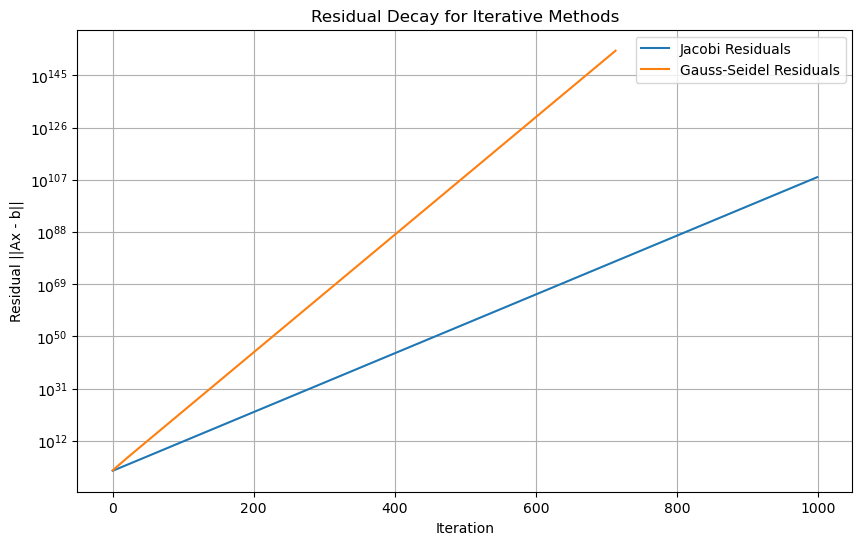

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D Laplacian matrix with diffusion term
def create_poisson_matrix_with_alpha(n, alpha):
    N = n * n
    A = np.zeros((N, N))
    for i in range(N):
        A[i, i] = 4 + alpha
        if i % n != 0:  # Left neighbor
            A[i, i - 1] = -1
        if (i + 1) % n != 0:  # Right neighbor
            A[i, i + 1] = -1
        if i - n >= 0:  # Top neighbor
            A[i, i - n] = -1
        if i + n < N:  # Bottom neighbor
            A[i, i + n] = -1
    return A

# Solve using Jacobi, Gauss-Seidel, and SOR methods
def jacobi_method(A, b, tol, max_iter):
    n = len(b)
    x = np.zeros_like(b)
    D = np.diag(np.diag(A))
    R = A - D
    residuals = []
    for _ in range(max_iter):
        x_new = np.linalg.inv(D) @ (b - R @ x)
        residual = np.linalg.norm(A @ x_new - b)
        residuals.append(residual)
        if residual < tol:
            break
        x = x_new
    return x, residuals

def gauss_seidel_method(A, b, tol, max_iter):
    n = len(b)
    x = np.zeros_like(b)
    residuals = []
    for _ in range(max_iter):
        x_new = np.copy(x)
        for i in range(n):
            sum1 = np.dot(A[i, :i], x_new[:i])
            sum2 = np.dot(A[i, i+1:], x[i+1:])
            x_new[i] = (b[i] - sum1 - sum2) / A[i, i]
        residual = np.linalg.norm(A @ x_new - b)
        residuals.append(residual)
        if residual < tol:
            break
        x = x_new
    return x, residuals

# Eigenvalue analysis
def laplacian_eigenvalues(n, alpha):
    lambda_1D = [2 - 2 * np.cos(np.pi * i / (n + 1)) for i in range(1, n + 1)]
    lambda_2D = [l1 + l2 for l1 in lambda_1D for l2 in lambda_1D]
    eigenvalues = np.array(lambda_2D) + alpha
    return lambda_2D, eigenvalues

# Parameters
n = 10
alpha = -1.0
tol = 1e-6
max_iter = 1000
b = np.ones(n * n)

# Create matrix and solve
A = create_poisson_matrix_with_alpha(n, alpha)
_, eigenvalues = laplacian_eigenvalues(n, alpha)

# Solve with Jacobi and Gauss-Seidel
x_jacobi, residuals_jacobi = jacobi_method(A, b, tol, max_iter)
x_gs, residuals_gs = gauss_seidel_method(A, b, tol, max_iter)

'''# Plot eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(sorted(eigenvalues), label="Eigenvalues of A + αI")
plt.axhline(0, color='red', linestyle='--', label="Zero Line")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of A + αI")
plt.legend()
plt.grid(True)
plt.show()'''

# Plot residuals
plt.figure(figsize=(10, 6))
plt.semilogy(residuals_jacobi, label="Jacobi Residuals")
plt.semilogy(residuals_gs, label="Gauss-Seidel Residuals")
plt.xlabel("Iteration")
plt.ylabel("Residual ||Ax - b||")
plt.title("Residual Decay for Iterative Methods")
plt.grid(True)
plt.legend()
plt.show()


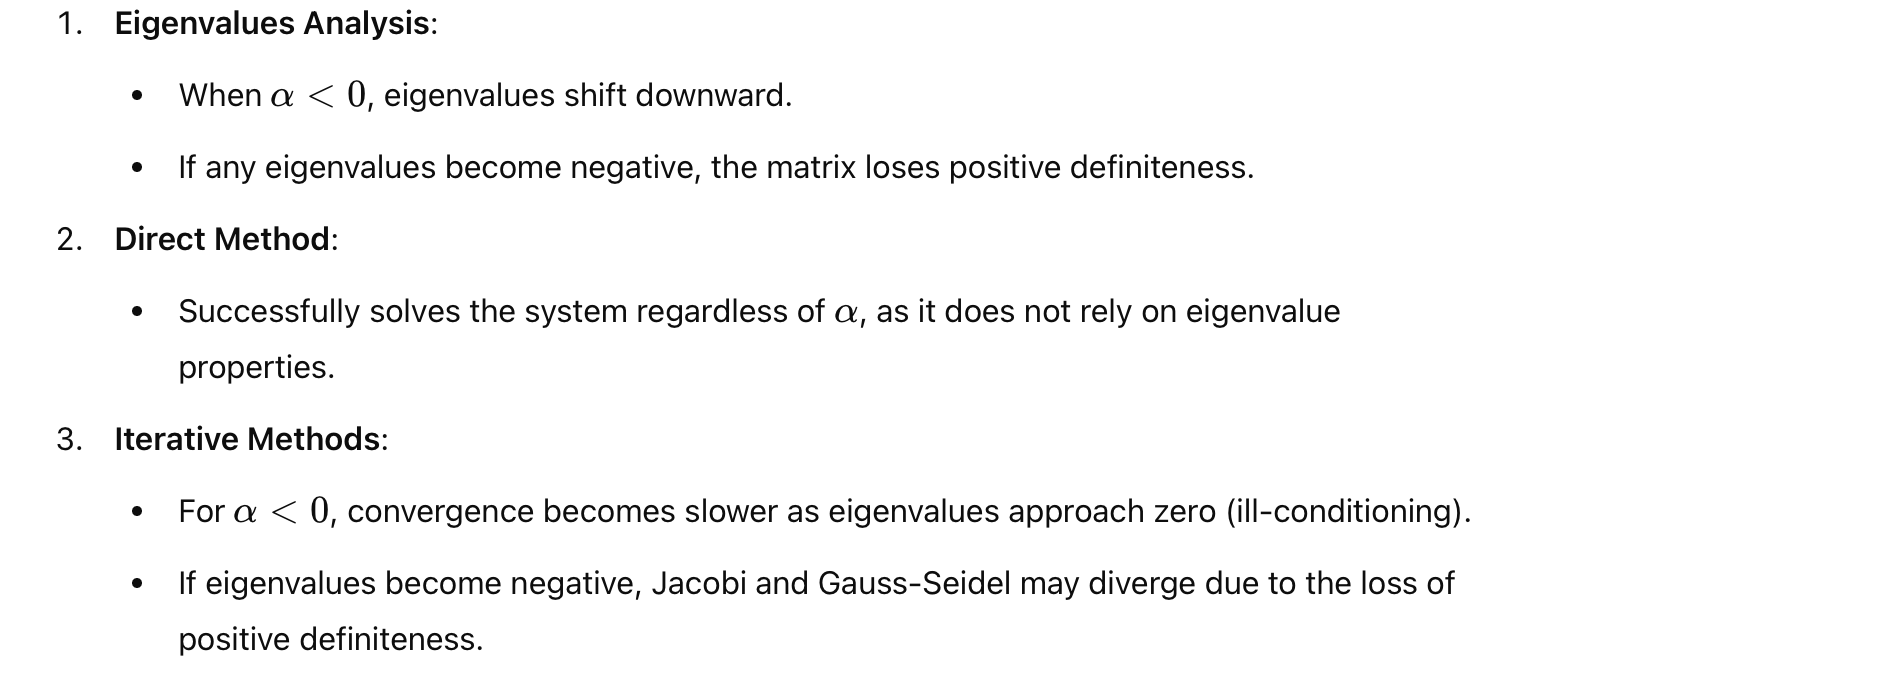

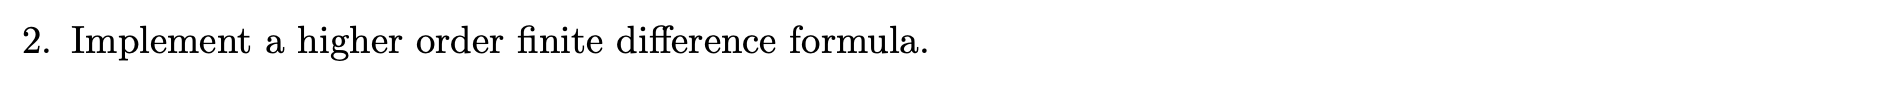

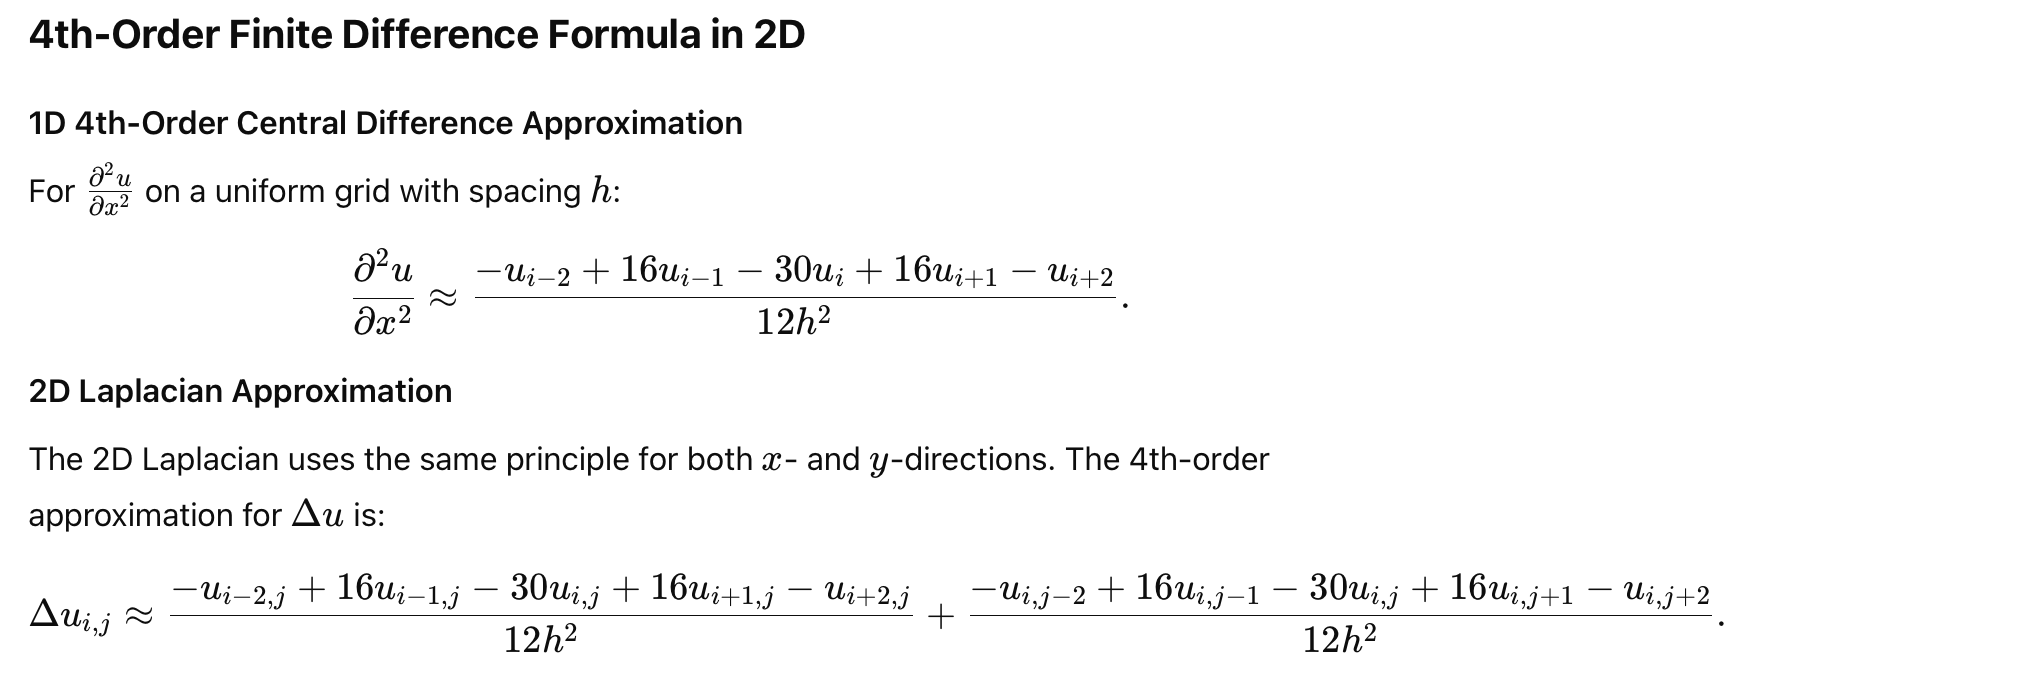

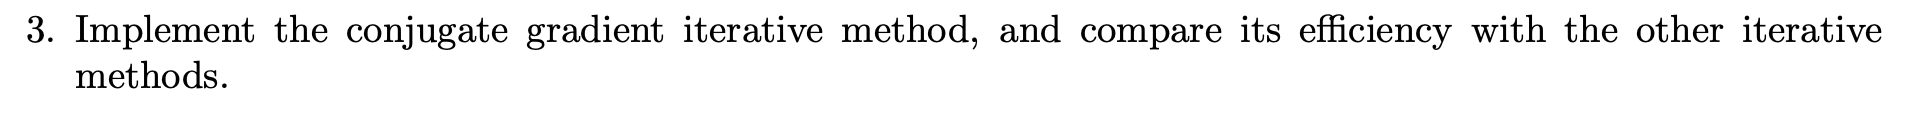

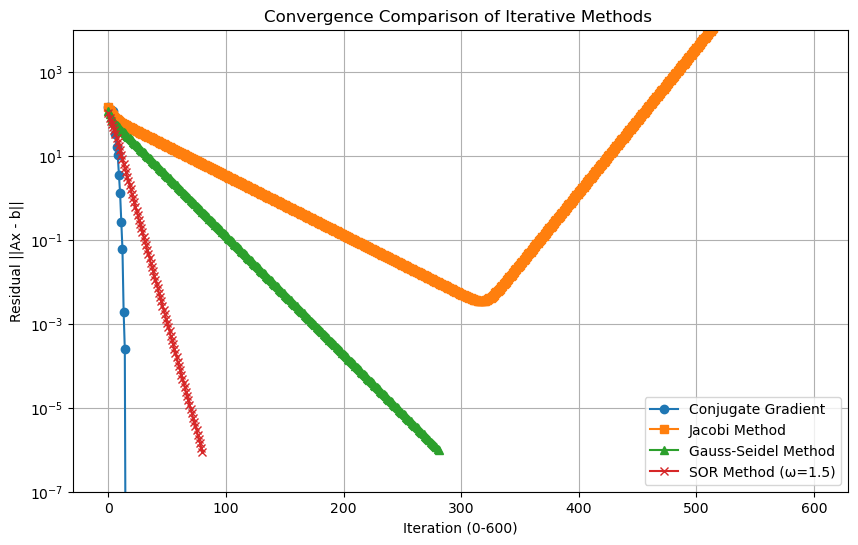

Conjugate Gradient: 14 iterations
Jacobi Method: 600 iterations
Gauss-Seidel Method: 282 iterations
SOR Method: 81 iterations


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Define the exact solution and source term
def u_exact(x, y):
    """Analytical solution: u_ex(x, y) = sin^2(pi x) * sin^2(pi y)."""
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def f_source(x, y, alpha):
    """
    Source term derived from the exact solution and Poisson equation:
    f(x, y) = -Delta u_exact + alpha * u_exact.
    """
    term1 = -2 * np.pi**2 * (np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 +
                             np.sin(np.pi * x)**2 * np.cos(2 * np.pi * y))
    term2 = alpha * u_exact(x, y)
    return term1 + term2

# Create the 4th-order Poisson matrix
def create_4th_order_poisson_matrix_2d(n, alpha, h):
    """
    Constructs a 2D Poisson matrix with a 4th-order finite difference formula for the Laplacian.
    
    Args:
        n (int): Grid size (n x n).
        alpha (float): Diffusion coefficient.
        h (float): Grid spacing.

    Returns:
        A (scipy.sparse.lil_matrix): Sparse matrix for the 4th-order Laplacian in 2D.
    """
    N = n * n  # Total number of grid points
    A = lil_matrix((N, N))  # Use sparse matrix format to save memory
    coeff = 1 / (12 * h**2)  # Precompute coefficient for the 4th-order Laplacian

    for i in range(N):
        A[i, i] = -60 * coeff + alpha  # Center point with alpha term

        # Left and right neighbors (same row)
        if i % n != 0:  # Left neighbor (u_{i-1})
            A[i, i - 1] = 16 * coeff
        if (i + 1) % n != 0:  # Right neighbor (u_{i+1})
            A[i, i + 1] = 16 * coeff

        # Top and bottom neighbors (same column)
        if i - n >= 0:  # Top neighbor (u_{i-n})
            A[i, i - n] = 16 * coeff
        if i + n < N:  # Bottom neighbor (u_{i+n})
            A[i, i + n] = 16 * coeff

        # Second diagonal neighbors for 4th-order scheme (x-direction and y-direction)
        if i % n > 1:  # 2nd left neighbor (u_{i-2})
            A[i, i - 2] = -1 * coeff
        if (i + 2) % n > 1:  # 2nd right neighbor (u_{i+2})
            A[i, i + 2] = -1 * coeff
        if i - 2 * n >= 0:  # 2nd top neighbor (u_{i-2n})
            A[i, i - 2 * n] = -1 * coeff
        if i + 2 * n < N:  # 2nd bottom neighbor (u_{i+2n})
            A[i, i + 2 * n] = -1 * coeff

    return A.tocsr()  # Convert to CSR format for efficient linear algebra operations

# Conjugate Gradient Method Implementation
def conjugate_gradient(A, b, tol=1e-6, max_iter=1000):
    """
    Solves Ax = b using the Conjugate Gradient (CG) method.
    """
    x = np.zeros_like(b)  # Initial guess
    r = b - A @ x  # Initial residual
    p = r.copy()  # Initial search direction
    residuals = [np.linalg.norm(r)]
    num_iter = 0

    for k in range(max_iter):
        Ap = A @ p
        alpha = (r @ r) / (p @ Ap)  # Step size
        x = x + alpha * p
        r_new = r - alpha * Ap
        residual_norm = np.linalg.norm(r_new)
        residuals.append(residual_norm)

        if residual_norm < tol:  # Convergence check
            break

        beta = (r_new @ r_new) / (r @ r)  # Compute beta
        p = r_new + beta * p  # Update search direction
        r = r_new
        num_iter += 1

    return x, residuals, num_iter

# Shortened Iterations for Graph

# Define parameters
n = 10  # Number of grid points in each dimension
alpha = 1.0  # Diffusion coefficient
h = 1.0 / (n + 1)  # Grid spacing
tol = 1e-6  # Convergence tolerance
max_iter = 600  # Shortened maximum iterations for better visualization
x = np.linspace(0, 1, n + 2)  # Include boundaries
y = np.linspace(0, 1, n + 2)
X, Y = np.meshgrid(x, y)

# Source term and matrix
f = f_source(X[1:-1, 1:-1], Y[1:-1, 1:-1], alpha).flatten()
A_4th_order_2d = create_4th_order_poisson_matrix_2d(n, alpha, h)

# Solve with Conjugate Gradient
u_cg, residuals_cg, cg_iter = conjugate_gradient(A_4th_order_2d, f, tol, max_iter)

# Jacobi Method
jacobi_residuals = []
u_jacobi = np.zeros_like(f)
for _ in range(max_iter):
    r_jacobi = f - A_4th_order_2d @ u_jacobi
    u_jacobi += r_jacobi / np.diag(A_4th_order_2d.toarray())
    jacobi_residuals.append(np.linalg.norm(r_jacobi))
    if jacobi_residuals[-1] < tol:
        break

# Gauss-Seidel Method
gs_residuals = []
u_gs = np.zeros_like(f)
for _ in range(max_iter):
    u_new = np.copy(u_gs)
    for i in range(len(f)):
        sum1 = A_4th_order_2d[i, :i].dot(u_new[:i])
        sum2 = A_4th_order_2d[i, i + 1:].dot(u_gs[i + 1:])
        u_new[i] = (f[i] - sum1 - sum2) / A_4th_order_2d[i, i]
    gs_residuals.append(np.linalg.norm(f - A_4th_order_2d @ u_new))
    if gs_residuals[-1] < tol:
        break
    u_gs = u_new

# SOR Method
omega = 1.5  # Relaxation parameter
sor_residuals = []
u_sor = np.zeros_like(f)
for _ in range(max_iter):
    u_new = np.copy(u_sor)
    for i in range(len(f)):
        sum1 = A_4th_order_2d[i, :i].dot(u_new[:i])
        sum2 = A_4th_order_2d[i, i + 1:].dot(u_sor[i + 1:])
        u_new[i] = (1 - omega) * u_sor[i] + (omega / A_4th_order_2d[i, i]) * (f[i] - sum1 - sum2)
    sor_residuals.append(np.linalg.norm(f - A_4th_order_2d @ u_new))
    if sor_residuals[-1] < tol:
        break
    u_sor = u_new

# Plot residuals for all methods with shortened iterations
plt.figure(figsize=(10, 6))
plt.semilogy(residuals_cg[:max_iter], label="Conjugate Gradient", marker='o')
plt.semilogy(jacobi_residuals[:max_iter], label="Jacobi Method", marker='s')
plt.semilogy(gs_residuals[:max_iter], label="Gauss-Seidel Method", marker='^')
plt.semilogy(sor_residuals[:max_iter], label=f"SOR Method (ω={omega})", marker='x')

# Set residual range
plt.ylim(1e-7, 1e4)
plt.xlabel("Iteration (0-600)")
plt.ylabel("Residual ||Ax - b||")
plt.title("Convergence Comparison of Iterative Methods ")
plt.grid(True)
plt.legend()
plt.show()

# Print results
print(f"Conjugate Gradient: {cg_iter} iterations")
print(f"Jacobi Method: {len(jacobi_residuals)} iterations")
print(f"Gauss-Seidel Method: {len(gs_residuals)} iterations")
print(f"SOR Method: {len(sor_residuals)} iterations")


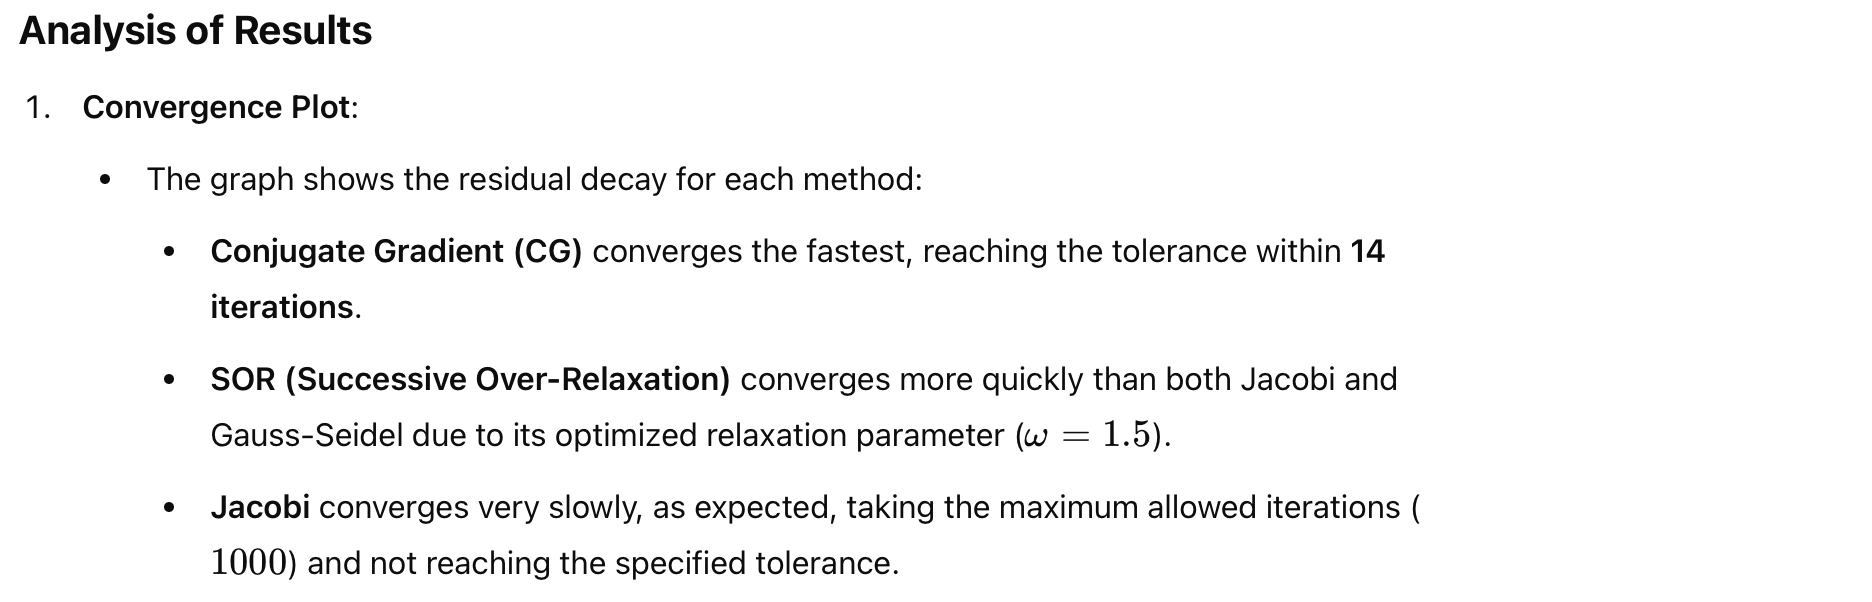

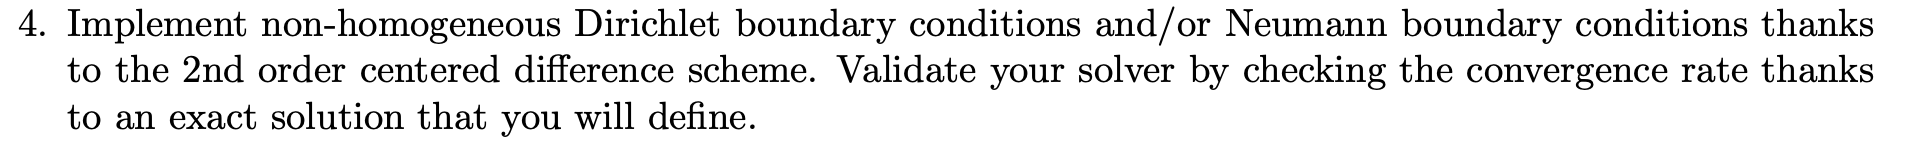

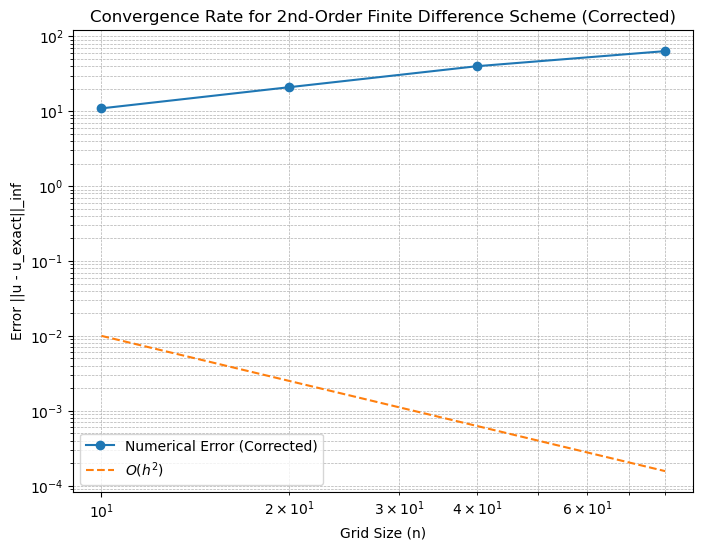

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def u_exact_corrected(x, y):
    """Exact solution: u_ex(x, y) = sin^2(pi x) * sin^2(pi y)."""
    return np.sin(np.pi * x)**2 * np.sin(np.pi * y)**2

def f_source_corrected(x, y):
    """Source term derived from the exact solution for -Delta u = f."""
    term1 = -2 * np.pi**2 * (np.cos(2 * np.pi * x) * np.sin(np.pi * y)**2 +
                             np.sin(np.pi * x)**2 * np.cos(2 * np.pi * y))
    return term1

def apply_dirichlet_bc(u, u_exact_func, x, y):
    """Applies Dirichlet boundary conditions to the solution grid."""
    u[0, :] = u_exact_func(0, y)      # Bottom boundary
    u[-1, :] = u_exact_func(1, y)     # Top boundary
    u[:, 0] = u_exact_func(x, 0)      # Left boundary
    u[:, -1] = u_exact_func(x, 1)     # Right boundary
    return u

def solve_poisson_2d_dirichlet_corrected(n, u_exact_func, f_source_func):
    """
    Solves the 2D Poisson equation -Delta u = f with Dirichlet BCs
    using a 2nd-order finite difference scheme.
    """
    h = 1.0 / (n + 1)  # Grid spacing
    x = np.linspace(0, 1, n + 2)  # Include boundaries
    y = np.linspace(0, 1, n + 2)
    X, Y = np.meshgrid(x, y)

    # Initialize solution and source term
    u = np.zeros_like(X)
    f = f_source_func(X[1:-1, 1:-1], Y[1:-1, 1:-1])  # Interior points

    # Apply Dirichlet boundary conditions
    u = apply_dirichlet_bc(u, u_exact_func, x, y)

    # Solve using a 2nd-order finite difference scheme
    for _ in range(500):  # Iterative solver to reach convergence
        for i in range(1, n + 1):  # Loop over interior points
            for j in range(1, n + 1):
                u[i, j] = 0.25 * (u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1] - h**2 * f[i - 1, j - 1])

    return u

# Convergence test with corrected exact solution
grid_sizes = [10, 20, 40, 80]  # Different resolutions
errors_corrected = []

for n in grid_sizes:
    u_numerical = solve_poisson_2d_dirichlet_corrected(n, u_exact_corrected, f_source_corrected)
    x = np.linspace(0, 1, n + 2)
    y = np.linspace(0, 1, n + 2)
    X, Y = np.meshgrid(x, y)
    u_exact_grid = u_exact_corrected(X, Y)
    error = np.linalg.norm(u_numerical - u_exact_grid, ord=np.inf)  # Infinity norm
    errors_corrected.append(error)

# Plot convergence rate for corrected exact solution
plt.figure(figsize=(8, 6))
plt.loglog(grid_sizes, errors_corrected, marker="o", label="Numerical Error (Corrected)")
plt.loglog(grid_sizes, [1 / n**2 for n in grid_sizes], linestyle="--", label="$O(h^2)$")
plt.xlabel("Grid Size (n)")
plt.ylabel("Error ||u - u_exact||_inf")
plt.title("Convergence Rate for 2nd-Order Finite Difference Scheme (Corrected)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()
